In [1]:
### Library
import numpy as np
import pandas as pd

import timeit
import time
import os
from datetime import datetime
from pathlib import Path

from tqdm import tqdm
from tqdm.auto import trange

import warnings
import pickle
import json
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, TensorDataset
from torchmetrics import regression
from collections import defaultdict
from pyro.optim import ClippedAdam
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoLowRankMultivariateNormal, AutoDiagonalNormal, AutoMultivariateNormal

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_squared_error

import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import math
import random

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'> Using device: {device}')

def set_seed(seed=12):
    np.random.seed(seed)
    torch.manual_seed(seed)
    pyro.set_rng_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

pyro.clear_param_store()
plt.style.use('ggplot')
set_seed(12)

> Using device: cuda:0


In [2]:
### Make result directory
script_dir = os.path.abspath('')
current_file = os.path.basename(globals()['__vsc_ipynb_file__']).replace('.ipynb', '')
dt_string = datetime.now().strftime("%y%m%d_%H%M%S")
result_dir = os.path.join(script_dir, 'Results', current_file, dt_string)
# Path(result_dir).mkdir(parents=True, exist_ok=True)

In [3]:
### Get data
data_df = pd.read_csv(os.path.join('Results', 'Climate_Sampling', '250129_172531', 'full_data_sampling.csv'), index_col=0, header=0)
data_df = data_df.drop_duplicates()

input_variables = ['$x_{1}$', '$x_{2}$', '$x_{3}$', '$x_{5}$', '$x_{8}$']
output_variables = [f'$y^{{{year}}}$' for year in range(2026, 2101)]

lst_input_features = []
lst_output_features = []

grouped = data_df.groupby('idx')

for design, group in tqdm(grouped):
    input_features = group[input_variables].iloc[0].values.tolist()
    output_features = group[output_variables].values.tolist()
    lst_input_features.append(input_features)
    lst_output_features.append(output_features)

# Convert to numpy arrays
lst_input_features = np.array(lst_input_features)
lst_output_features = np.array(lst_output_features)

# Scale input data
scaler_input = StandardScaler().fit(lst_input_features)
input_array = scaler_input.transform(lst_input_features)

# Scale output data
scalers_output = [StandardScaler().fit([lst_output_features[i][j].tolist() for i in range(len(lst_output_features))]) for j in range(lst_output_features.shape[1])]
output_array = np.stack([scalers_output[j].transform([lst_output_features[i][j].tolist() for i in range(len(lst_output_features))]) for j in range(lst_output_features.shape[1])], axis=1)

# Convert to tensors
data_input_tensor = torch.tensor(input_array, dtype=torch.float32).to(device)
data_output_tensor = torch.tensor(output_array, dtype=torch.float32).to(device)
torch.cuda.empty_cache()
data_tensor = TensorDataset(data_input_tensor, data_output_tensor)

print('----- Data demonstration -----')
print(f'> Input data:')
print(f'Input tensor shape: {data_input_tensor.shape}')
print(f'> Output data:')
print(f'Output tensor shape: {data_output_tensor.shape}')

print('----- Data summary -----')
print(f'> Number of data samples: {len(data_tensor)} samples')


100%|██████████| 199200/199200 [00:47<00:00, 4194.05it/s]


----- Data demonstration -----
> Input data:
Input tensor shape: torch.Size([199200, 5])
> Output data:
Output tensor shape: torch.Size([199200, 5, 75])
----- Data summary -----
> Number of data samples: 199200 samples


In [4]:
parameter_gama = 4.0
parameter_gama_rate = 0.5
parameter_prior_scale_input = 7.0
parameter_prior_scale_hidden = 8.0
parameter_prior_scale_output = 4.0

class BNN(PyroModule):
    def __init__(self, in_dim=5, out_dim=75, hid_dim=128, device='cuda'):
        super(BNN, self).__init__()
        self.activation = nn.LeakyReLU(0.1)
        self.dropout = PyroModule[nn.Dropout](0.05)
        self.out_dim = out_dim  
        self.device = device
        
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.layer3 = PyroModule[nn.Linear](hid_dim, hid_dim)

        # 5 layers for 5 scenarios
        self.layer4_sc1 = PyroModule[nn.Linear](hid_dim, out_dim)
        self.layer4_sc2 = PyroModule[nn.Linear](hid_dim, out_dim)
        self.layer4_sc3 = PyroModule[nn.Linear](hid_dim, out_dim)
        self.layer4_sc4 = PyroModule[nn.Linear](hid_dim, out_dim)
        self.layer4_sc5 = PyroModule[nn.Linear](hid_dim, out_dim)

        # Prior scales
        self.prior_scale_input = parameter_prior_scale_input
        self.prior_scale_hidden = parameter_prior_scale_hidden
        self.prior_scale_output = parameter_prior_scale_output

        # Set priors for each layer
        self.layer1.weight = PyroSample(
            dist.Normal(torch.zeros(hid_dim, in_dim, device=device),
                        self.prior_scale_input * torch.ones(hid_dim, in_dim, device=device)).to_event(2)
        )
        self.layer1.bias = PyroSample(
            dist.Normal(torch.zeros(hid_dim, device=device),
                        self.prior_scale_input * torch.ones(hid_dim, device=device)).to_event(1)
        )

        self.layer2.weight = PyroSample(
            dist.Normal(torch.zeros(hid_dim, hid_dim, device=device),
                        self.prior_scale_hidden * torch.ones(hid_dim, hid_dim, device=device)).to_event(2)
        )
        self.layer2.bias = PyroSample(
            dist.Normal(torch.zeros(hid_dim, device=device),
                        self.prior_scale_hidden * torch.ones(hid_dim, device=device)).to_event(1)
        )

        self.layer3.weight = PyroSample(
            dist.Normal(torch.zeros(hid_dim, hid_dim, device=device),
                        self.prior_scale_hidden * torch.ones(hid_dim, hid_dim, device=device)).to_event(2)
        )
        self.layer3.bias = PyroSample(
            dist.Normal(torch.zeros(hid_dim, device=device),
                        self.prior_scale_hidden * torch.ones(hid_dim, device=device)).to_event(1)
        )

        # Priors for 5 scenarios output layers
        for sc in range(1, 6):
            layer = getattr(self, f"layer4_sc{sc}")
            layer.weight = PyroSample(
                dist.Normal(torch.zeros(out_dim, hid_dim, device=device),
                            self.prior_scale_output * torch.ones(out_dim, hid_dim, device=device)).to_event(2)
            )
            layer.bias = PyroSample(
                dist.Normal(torch.zeros(out_dim, device=device),
                            self.prior_scale_output * torch.ones(out_dim, device=device)).to_event(1)
            )

    def forward(self, x, y=None):
        x = x.to(self.device).float()
        batch_size = x.shape[0]
        if len(x.shape) > 2:
            x = x.reshape(batch_size, -1)

        x = self.activation(self.layer1(x))
        x = self.dropout(x)
        residual = x
        x = self.activation(self.layer2(x))
        x = self.dropout(x)
        x = self.activation(self.layer3(x))
        x = x + residual

        # Calculate mu for each scenario
        mu_sc1 = self.layer4_sc1(x)
        mu_sc2 = self.layer4_sc2(x)
        mu_sc3 = self.layer4_sc3(x)
        mu_sc4 = self.layer4_sc4(x)
        mu_sc5 = self.layer4_sc5(x)
        mu = torch.stack([mu_sc1, mu_sc2, mu_sc3, mu_sc4, mu_sc5], dim=1)  # [batch_size, 5, 76]

        # Sample df and sigma
        df = pyro.sample("df", 
                        dist.Gamma(concentration=torch.tensor(parameter_gama, device=self.device), 
                                rate=torch.tensor(parameter_gama_rate, device=self.device)))
        sigma = pyro.sample("sigma", 
                        dist.HalfCauchy(torch.ones(5, self.out_dim, device=self.device)).to_event(2))

        # Chose likelihood for each scenario
        with pyro.plate("data", batch_size):
            for i in range(5):
                pyro.sample(f"obs_sc{i}", 
                        dist.StudentT(df=df, loc=mu[:, i, :], scale=sigma[i, :]).to_event(1), 
                        obs=y[:, i, :] if y is not None else None)

        return mu
    
    def hyperparameter_init(self, loss_func, guide, optimizer):
        self.loss_func = loss_func
        self.guide = guide
        self.optimizer = optimizer
        self.svi = SVI(self, self.guide, self.optimizer, loss=self.loss_func)
        self.history = {}
        self.save_path = None
        return

    def epoch_train(self, data_input, data_output):
        epoch_loss = self.svi.step(data_input, data_output) / data_input.shape[0]
        return epoch_loss

    def stop_condition(self, tol, patience, num_epochs):
        epoch = len(self.history['train_loss']) - 1
        self.max_epoch = epoch
        if epoch < 1:
            self.best_epoch = 0
            return False

        if self.history['train_loss'][epoch] <= self.history['train_loss'][self.best_epoch]:
            self.best_epoch = epoch
            self.best_guide = self.guide
            self.best_param_store = pyro.get_param_store()
            self.best_history = {key: value[epoch] for key, value in self.history.items()}

        if self.history['train_loss'][epoch] <= tol:
            print(f'> Early stopping at epoch {epoch+1:03} due to reaching the tolerance of {tol:.3f}')
            return True

        if epoch + 1 >= patience and min(self.history['train_loss'][-patience:]) > self.history['train_loss'][self.best_epoch]:
            print(f'> Early stopping at epoch {epoch+1:03} due to reaching maximum patience of {patience}')
            return True

        if epoch + 1 == num_epochs:
            print(f'> Model stopping at epoch {epoch+1:03} due to reaching maximum epochs {num_epochs}')
            return True
        return False

    def plot_loss(self):
        if epoch < 1:
            plt.ion()  # Turn on interactive mode
            plt.rcParams['text.usetex'] = True
            self.fig, self.ax = plt.subplots(figsize=(8, 6))
            self.train_loss_line, = self.ax.plot([], [], label="Train Loss", color='b',
                                                linestyle='-', linewidth=2)
            self.fig.suptitle(r'\textbf{Training history}', y=0.99, fontsize=16)
            self.ax.set_xlabel('Epochs', fontsize=12)
            self.ax.set_ylabel('Loss', fontsize=12)
            self.ax.tick_params(axis='x', labelsize=10)
            self.ax.tick_params(axis='y', labelsize=10)
            self.ax.set_yscale('log')
            self.ax.legend(loc='upper right', fontsize=10)
            plt.tight_layout()
            plt.grid(True)
            # self.fig.canvas.manager.window.activateWindow()
            # self.fig.canvas.manager.window.raise_()
        else:
            self.train_loss_line.set_data(range(epoch+1), self.history["train_loss"])

            self.ax.set_xlim(0, epoch + 1)
            self.ax.set_ylim(min(self.history["train_loss"])*0.8, max(self.history["train_loss"])*1.2)
            # self.ax.relim()
            # self.ax.autoscale_view()

            self.fig.canvas.draw()
            self.fig.canvas.flush_events()
        return

In [5]:
### Training process
# %matplotlib qt
print('----- Training process -----')
save_path = os.path.join(result_dir, datetime.now().strftime("%H%M%S"))
Path(save_path).mkdir(parents=True, exist_ok=True)

model = BNN(in_dim=5, out_dim=75, hid_dim=128, device=device)
model.hyperparameter_init(loss_func = Trace_ELBO(),
                          guide = AutoLowRankMultivariateNormal(model, rank=10),
                          optimizer = pyro.optim.AdamW({"lr": 0.01, "weight_decay": 5e-4}))
pyro.clear_param_store()

model.history = {'train_loss': []}
model.save_path = save_path

num_epochs = 50000
progress_bar = trange(num_epochs)
for epoch in progress_bar:

    # Train loop
    train_loss = model.epoch_train(data_input_tensor, data_output_tensor)
    model.history['train_loss'].append(train_loss)

    # Print epoch metrics
    progress_bar.set_postfix(loss=f"{train_loss:.3f}")
#     print(f'> Epoch [{epoch+1:03}/{num_epochs:03}]:\n'
#           f' > ELBO Loss: Train: {train_loss:.3f}')
    
    # Stop training and save model
    if model.stop_condition(tol=-1e3, patience=500, num_epochs=num_epochs):
        best_loss = [model.best_history[key] for key in ['train_loss']]
        print(f'> Model is saved at epoch {model.best_epoch+1:03}:\n'
              f' > MSE Loss: Train: {best_loss[0]:.3f}')
        break
    
# %matplotlib inline
# plt.ioff()
# plt.show()

----- Training process -----


 21%|██        | 10374/50000 [18:28<1:10:34,  9.36it/s, loss=-24.181]

> Early stopping at epoch 10375 due to reaching maximum patience of 500
> Model is saved at epoch 9875:
 > MSE Loss: Train: -32.166


In [6]:
### Save results
data_to_save = {
    'model': 'BayesianNeuralNetwork',
    # 'data_input': data_input_df,
    # 'data_output': data_output_df,
    # 'data_size': data_size,
    # 'batch_size': batch_size,
    'history': model.history,
    'best_epoch': model.best_epoch,
    'best_history': model.best_history,
    'save_path': model.save_path,
    # 'best_model_parameters': model.best_model,
    # 'best_optimizer_parameters': model.best_optimizer,
}

with open(os.path.join(save_path, 'Results.json'), 'w') as f:
    json.dump(data_to_save, f)

torch.save(model, os.path.join(save_path, 'BNN_model.pt'))

with open(os.path.join(save_path, 'Best_BNN_guide.pkl'), 'wb') as f:
    pickle.dump(model.best_guide, f)
model.best_param_store.save(os.path.join(save_path, 'Best_BNN_params.pt'))

print(save_path)

/home/nqduong/nqduong_CIRTECH/BuildingGhent/Results/BNN_Model_Fixed/250325_173646/173829


In [5]:
### Load saved model
load_path = os.path.join(script_dir, 'Results', current_file, '250326_085053', '091909')
# load_path = save_path

pyro.clear_param_store()
model = torch.load(os.path.join(load_path, 'BNN_model.pt'), map_location=device, weights_only=False)
with open(os.path.join(load_path, 'Best_BNN_guide.pkl'), 'rb') as f:
    guide = pickle.load(f)
    
# Load the params file with weights_only=False
with open(os.path.join(load_path, 'Best_BNN_params.pt'), 'rb') as input_file:
    state = torch.load(input_file, map_location=device, weights_only=False)
    
# Set the state in the param store
pyro.get_param_store().set_state(state)

In [6]:
### Evaluate the model
print('----- Model evaluation -----')
model.eval()
guide.requires_grad_(False)

train_best_loss = model.history["train_loss"][model.best_epoch]
recal_best_loss = Trace_ELBO().loss(model, guide, data_input_tensor, data_output_tensor) / data_input_tensor.shape[0]

print(f'> Saved best loss: {train_best_loss:.3f}')
print(f'> Recalculated best loss: {recal_best_loss:.3f}')

predictive = Predictive(model, guide=guide, num_samples=200, return_sites=("_RETURN", "obs_sc0", "obs_sc1", "obs_sc2", "obs_sc3", "obs_sc4"))

mean_obs_output = data_output_tensor.reshape(-1, 200, 5, 75).permute(1, 0, 2, 3).cpu().numpy().mean(axis=0)
data_unique_tensor = torch.from_numpy(pd.DataFrame(data_input_tensor.cpu().numpy()).drop_duplicates().values).float().to(device)
mean_pred_output = predictive(data_unique_tensor)['_RETURN'].cpu().numpy().mean(axis=0)
# mean_pred_output = torch.stack([predictive(data_unique_tensor)[f'obs_sc{i}'] for i in range(5)], dim=2).cpu().numpy().mean(axis=0)

mean_obs_output = np.array([scalers_output[i].inverse_transform(mean_obs_output[:, i, :]) for i in range(lst_output_features.shape[1])]).transpose(1, 0, 2)
mean_pred_output = np.array([scalers_output[i].inverse_transform(mean_pred_output[:, i, :]) for i in range(lst_output_features.shape[1])]).transpose(1, 0, 2)

RMSE = np.sqrt(mean_squared_error(mean_obs_output.flatten(), mean_pred_output.flatten()))
MAPE = mean_absolute_percentage_error(mean_obs_output.flatten(), mean_pred_output.flatten())*100.

print(f'> Overall RMSE: {RMSE:.3f}')
print(f'> Overall MAPE: {MAPE:.3f}%')

RMSE_list = [np.sqrt(mean_squared_error(mean_obs_output[i,:], mean_pred_output[i,:]))
             for i in range(mean_obs_output.shape[0])]
MAPE_list = [mean_absolute_percentage_error(mean_obs_output[i,:], mean_pred_output[i,:])*100
             for i in range(mean_obs_output.shape[0])]

print(f'> Per-sample RMSE: {np.min(RMSE_list):.3f} (Min), {np.mean(RMSE_list):.3f} (Mean), {np.max(RMSE_list):.3f} (Max)')
print(f'> Per-sample MAPE: {np.min(MAPE_list):.3f}% (Min), {np.mean(MAPE_list):.3f}% (Mean), {np.max(MAPE_list):.3f}% (Max)')


----- Model evaluation -----
> Saved best loss: -60.083
> Recalculated best loss: -16.450
> Overall RMSE: 0.591
> Overall MAPE: 1.767%
> Per-sample RMSE: 0.061 (Min), 0.503 (Mean), 1.463 (Max)
> Per-sample MAPE: 0.288% (Min), 1.767% (Mean), 3.851% (Max)


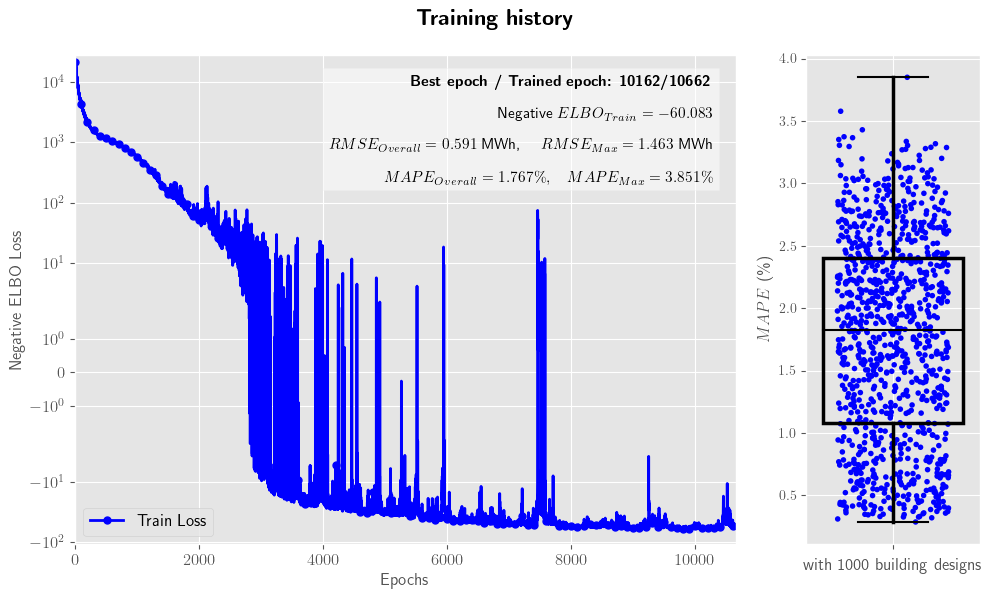

In [8]:
### Plot final training history
trained_epochs = range(model.max_epoch+1)
trained_history = {key: model.history[key][:model.max_epoch+1] for key in model.history.keys()}
best_loss = [model.best_history[key] for key in ['train_loss']]
best_metric = [RMSE, MAPE]
best_metric_list = [[max(RMSE_list), min(RMSE_list)],
                    [max(MAPE_list), min(MAPE_list)]]

plt.rcParams['text.usetex'] = True
[nrows, ncols] = [3, 4]
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(nrows, ncols)
fig.suptitle(r'\textbf{Training history}', y=0.99, fontsize=16)

ax1 = fig.add_subplot(gs[:, :-1])
train_loss_line, = ax1.plot(trained_epochs, trained_history["train_loss"],
                           label="Train Loss", color='b',
                           linestyle='-', linewidth=2, marker='o', ms=5, markevery=100)

ax1.set_xlabel(r'Epochs', fontsize=12)
ax1.set_ylabel(r'Negative ELBO Loss', fontsize=12)
ax1.set_xlim(0, model.max_epoch + 1)
ax1.set_ylim(np.min([trained_history[key] for key in ["train_loss"]])*1.8,
             np.max([trained_history[key] for key in ["train_loss"]])*1.2)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_yscale('symlog')
ax1.legend(loc='lower left', fontsize=12)

ax1.text(0.965, 0.96,
         r'\textbf{Best epoch / Trained epoch: ' + rf'{model.best_epoch+1:03}' + '/' + rf'{model.max_epoch+1:03}' + '}\n\n' +
         r'Negative $ELBO_{Train} = ' + rf'{best_loss[0]:.3f}' + '$\n\n' +
         r'$RMSE_{Overall} = ' + rf'{best_metric[0]:.3f}$ MWh' + r', $\quad RMSE_{Max} = ' + rf'{best_metric_list[0][0]:.3f}$ MWh' + '\n\n' +
         r'$MAPE_{Overall} = ' + rf'{best_metric[1]:.3f}\%' + r', \quad MAPE_{Max} = ' + rf'{best_metric_list[1][0]:.3f}\%$',
         transform=ax1.transAxes, fontsize=11,
         ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

ax2 = fig.add_subplot(gs[:, -1:])
pal = sns.color_palette("tab20", n_colors=len(output_variables))
sns.stripplot(ax=ax2, data=MAPE_list, color='blue', edgecolor='white', size=4, jitter=0.32, zorder=1, orient='v')
sns.boxplot(ax=ax2, data=MAPE_list, color='black', width=0.8, zorder=10, showcaps=True, boxprops = {'facecolor':'none', "zorder":10, 'linewidth':2.5},
            showfliers=True, whiskerprops ={'linewidth':2.5, "zorder":10}, saturation=1, orient = 'v')
ax2.set_xlabel(rf'with 1000 building designs', fontsize=12)
ax2.set_xticklabels('', fontsize=10)
ax2.set_ylabel(r'$MAPE$' + r' (\%)', fontsize=12)

plt.grid(True)
plt.tight_layout(rect=(0, 0, 1, 1))
plt.subplots_adjust(wspace=0.4)
plt.savefig(os.path.join(result_dir, 'Train_History.png'), dpi=400)
plt.show()


[220.0, 260.0, 1.2, 0.2, 26.5]


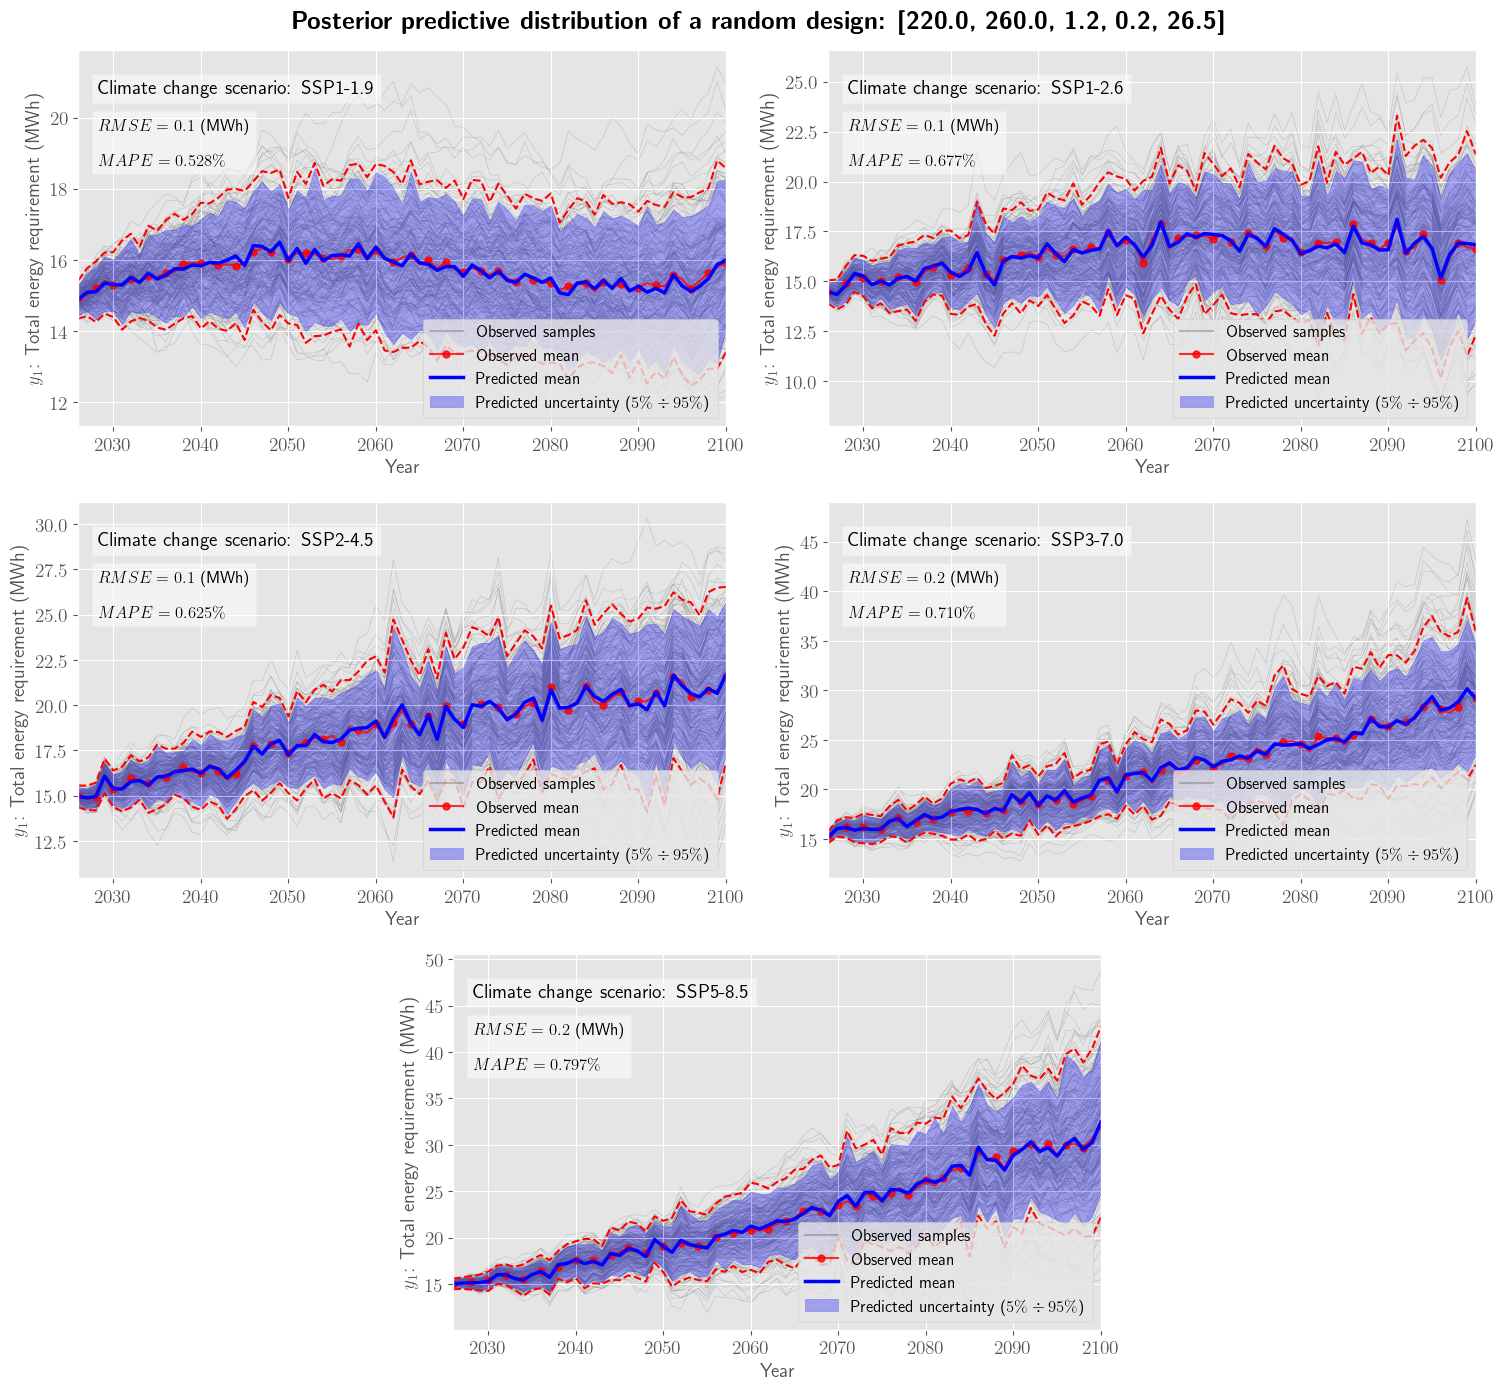

In [ ]:
### Predict the random design sample
design_sample = data_df[input_variables].drop_duplicates()
# random_sample = design_sample.iloc[58].to_numpy().tolist()  # Baseline design sample: [300, 200, 0.4, 1.8, 26]
random_sample = design_sample.sample(1).to_numpy().tolist()[0]
print(random_sample)

random_sample_input_tensor = scaler_input.transform(np.array(random_sample).reshape(1,-1))
random_sample_input_tensor = torch.from_numpy(random_sample_input_tensor).float().to(device)
random_sample_output_df = data_df[np.all(data_df[input_variables] == random_sample, axis=1)][output_variables]
random_sample_output_array = random_sample_output_df.to_numpy().reshape(5, -1, 75).transpose(1, 0, 2)
random_sample_output_array = np.stack([scalers_output[j].transform([random_sample_output_array[i][j].tolist() for i in range(len(random_sample_output_array))]) for j in range(random_sample_output_array.shape[1])], axis=1)

sample_output_tensor = {'obs': torch.from_numpy(random_sample_output_array).float().to(device),
                        # 'pred': predictive(random_sample_input_tensor)['_RETURN'].squeeze(1)}
                        'pred': torch.stack([predictive(random_sample_input_tensor)[f'obs_sc{i}'] for i in range(5)], dim=1).squeeze(2)}

for key, value in sample_output_tensor.items():
        sample_output_tensor[key] = {
            'mean': torch.mean(value, 0),
            'low_5': value.kthvalue(int(len(value) * 0.05), dim=0)[0],
            'high_95': value.kthvalue(int(len(value) * 0.95), dim=0)[0],
        }

        for sub_key, sub_value in sample_output_tensor[key].items():
            sample_output_tensor[key][sub_key] = np.stack([scalers_output[j].inverse_transform([sub_value[j,:].tolist()]) for j in range(sub_value.shape[0])], axis=1).reshape(5, 75).transpose()
            sample_output_tensor[key][sub_key] = [pd.DataFrame(sample_output_tensor[key][sub_key][:,i], index=range(2026,2101)) for i in range(sub_value.shape[0])]

        sample_output_tensor[key]['data'] = np.stack([scalers_output[j].inverse_transform([value[i][j].tolist() for i in range(len(value))]) for j in range(value.shape[1])], axis=1)
        sample_output_tensor[key]['data'] = [pd.DataFrame(sample_output_tensor[key]['data'][:,i,:].transpose(), index=range(2026,2101), columns=['sample_'+str(j) for j in range(sample_output_tensor[key]['data'].shape[0])]) for i in range(value.shape[1])]

        sample_output_tensor[key]['std'] = np.asarray(torch.std(value, 0).cpu().numpy() * [scalers_output[j].scale_ for j in range(value.shape[1])]).transpose()
        sample_output_tensor[key]['std'] = [pd.DataFrame(sample_output_tensor[key]['std'][:,i], index=range(2026,2101)) for i in range(sub_value.shape[0])]

plt.rcParams['text.usetex'] = True
[nrows, ncols] = [2, 2]
fig = plt.figure(figsize=(15, 14))
fig.suptitle(r'\textbf{Posterior predictive distribution of a random design: ' + rf'{str(random_sample)}' + '}', y=0.99, fontsize=18)

gs = gridspec.GridSpec(nrows+1, ncols*2, figure=fig)
axes = [fig.add_subplot(gs[i, 2*j:2*j+2]) for i in range(nrows) for j in range(ncols)]
axes.append(fig.add_subplot(gs[2, 1:3]))

climate_change_scenarios = ['SSP1-1.9', 'SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']
for i in range(len(climate_change_scenarios)):
    col = climate_change_scenarios[i]
    ax1 = axes[i]

    mean_obs_sample_output = sample_output_tensor['obs']['mean'][i]
    mean_pred_sample_output = sample_output_tensor['pred']['mean'][i]

    RMSE_sample = np.sqrt(mean_squared_error(mean_obs_sample_output, mean_pred_sample_output))
    MAPE_sample = mean_absolute_percentage_error(mean_obs_sample_output, mean_pred_sample_output)*100

    for j in range(sample_output_tensor['obs']['data'][i].shape[1]):
        ax1.plot(sample_output_tensor['obs']['data'][i]['sample_'+str(j)], alpha=0.5, linewidth=0.3, color='gray', zorder=-1)
    ax1.plot([], [], color='gray', alpha=0.5, label='Observed samples', zorder=-1)

    ax1.plot(mean_obs_sample_output, label="Observed mean", color='red', linestyle='-', linewidth=1.5, marker='o', ms=5, markevery=2, alpha=0.8)
    ax1.plot(mean_pred_sample_output, label="Predicted mean", color='blue', linestyle='-', linewidth=2.5)

    # z_low, z_high = stats.norm.ppf(0.5 - 0.6827 / 2), stats.norm.ppf(0.5 + 0.6827 / 2)
    z_low, z_high = stats.norm.ppf(0.5 - 0.9500 / 2), stats.norm.ppf(0.5 + 0.9500 / 2)
    ax1.plot(sample_output_tensor['pred']['mean'][i] + z_low*sample_output_tensor['pred']['std'][i], 'r--')
    ax1.plot(sample_output_tensor['pred']['mean'][i] + z_high*sample_output_tensor['pred']['std'][i], 'r--')

    ax1.fill_between(sample_output_tensor['pred']['mean'][i].index,
                     sample_output_tensor['pred']['low_5'][i].values.flatten(),
                     sample_output_tensor['pred']['high_95'][i].values.flatten(),
                     label=r'Predicted uncertainty ($5\% \div 95\%$)', color='blue', alpha=0.3, zorder=1)

    ax1.set_xlabel(r'Year', fontsize=14)
    ax1.set_ylabel(r'$y_{1}$: Total energy requirement (MWh)', fontsize=14)
    ax1.legend(loc='lower right', ncols=1, fontsize=12)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)
    ax1.set_xlim(min(sample_output_tensor['pred']['mean'][i].index), max(sample_output_tensor['pred']['mean'][i].index))
    ax1.get_ylim()
    ax1.text(0.03, 0.92, rf'Climate change scenario: {col}', transform=ax1.transAxes, fontsize=14,
             ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))

    ax1.text(0.03, 0.82,
            r'$RMSE = ' + rf'{RMSE_sample:.1f}$ (MWh)' + '\n\n' +
            r'$MAPE = ' + rf'{MAPE_sample:.3f}\%$',
            transform=ax1.transAxes, fontsize=12,
            ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
    # break

plt.tight_layout(rect=(0, 0, 1, 1))
plt.subplots_adjust(hspace=0.2)
plt.savefig(os.path.join(result_dir, 'Random_sample_y1.png'), dpi=400)
plt.show()
